# Titanic competition

In [1]:
import jupyterthemes as jt
from jupyterthemes import jtplot
!jt -l
!jt -t onedork -ofs 10 -dfs 9 -nfs 11 -tfs 11
jtplot.style(theme = 'onedork', fscale = 1.4 , context = 'notebook', ticks = True, 
             grid = False)

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn import linear_model, metrics
from matplotlib import pylab as plt
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats as sts
import re
import seaborn as sns
import string
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Python\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
data_train = pd.read_csv('train_titanic.csv')
data_test = pd.read_csv('test_titanic.csv')
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Выделим целевую переменную и тестовый id пассажиров
target = data_train['Survived']
id_test = data_test['PassengerId']

#Удалим id пассажиров
data_train.drop(columns = ['PassengerId'], axis = 1, inplace = True)
data_test.drop(columns = ['PassengerId'], axis = 1, inplace = True)

#объединим датасеты
all_data = pd.concat([data_train.drop(columns = ['Survived'], axis = 1), data_test])

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 86.9+ KB


In [6]:
all_data.describe()

,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


# EDA

# Categorial features

In [7]:
cat_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

In [8]:
data_train[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
Pclass      891 non-null int64
Sex         891 non-null object
SibSp       891 non-null int64
Parch       891 non-null int64
Embarked    889 non-null object
dtypes: int64(3), object(2)
memory usage: 27.9+ KB


Выживаемость пассажиров из 3 класса существенно ниже, чем из первых двух

Женщин выживает намного больше, чем мужчин

<Figure size 720x216 with 0 Axes>

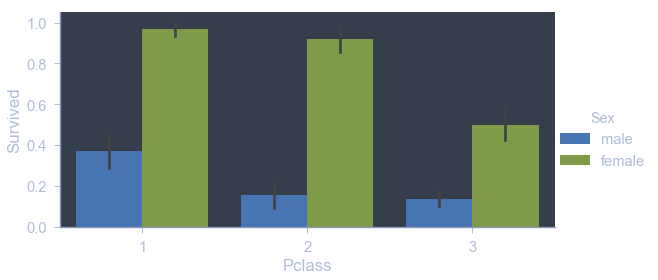

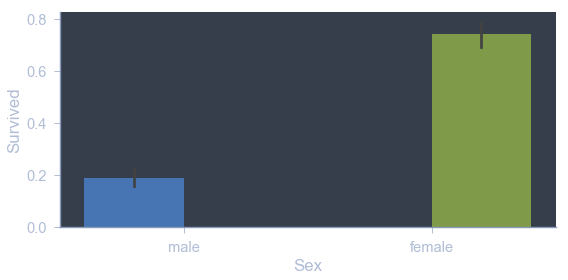

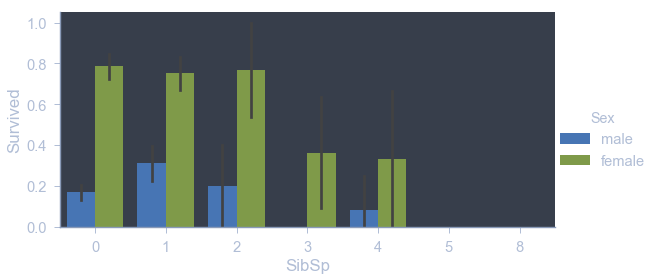

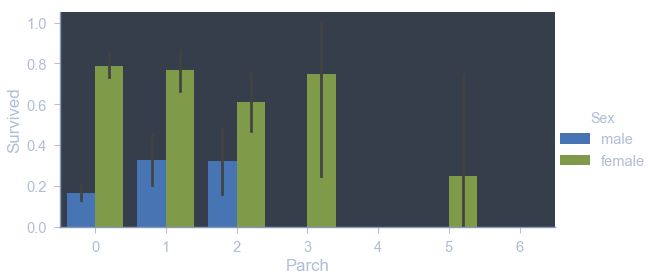

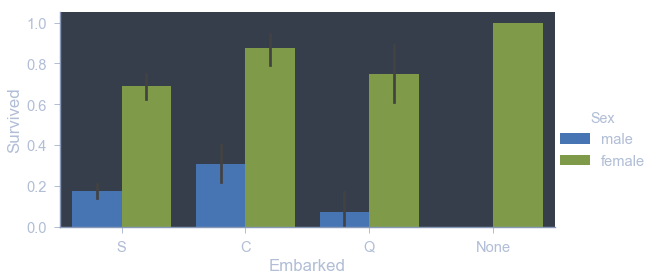

In [9]:
plt.figure(figsize(10, 3))
for i, feature in enumerate(cat_features):
    sns.catplot(x = feature, y = 'Survived', hue = 'Sex', data = data_train.fillna('None'), kind = 'bar',
                height = 4, aspect = 2)
    plt.show()  

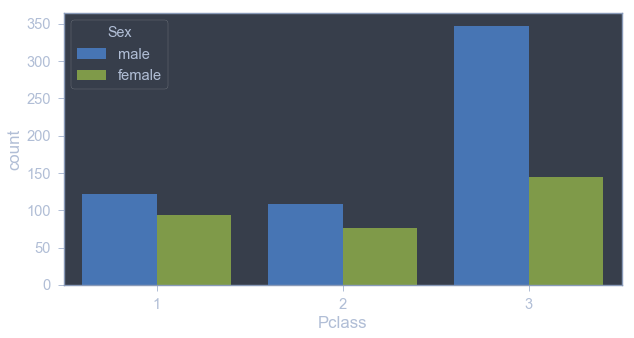

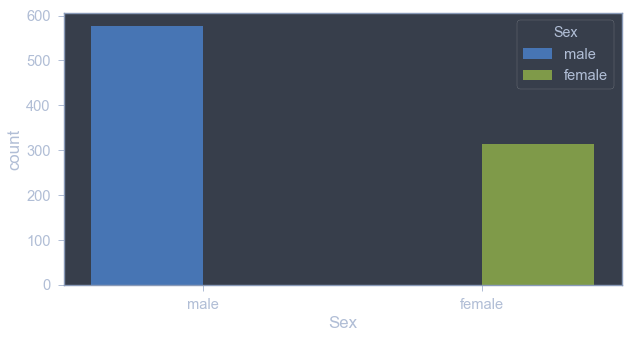

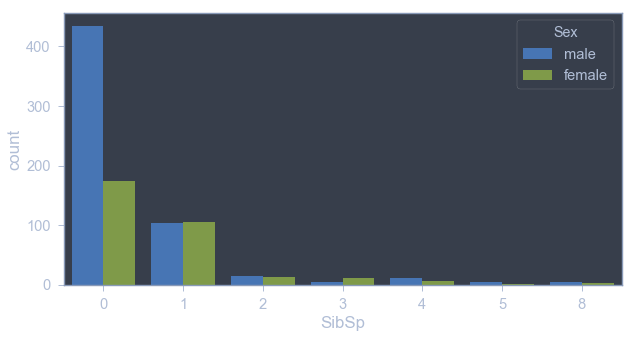

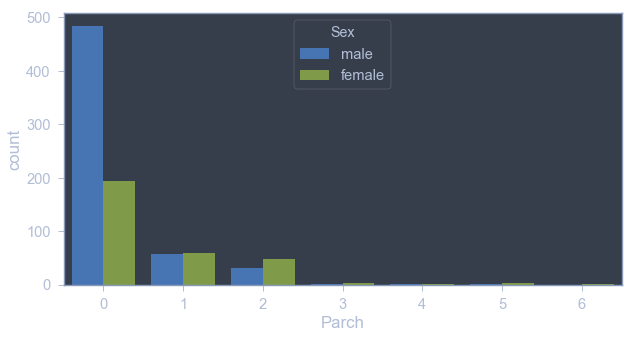

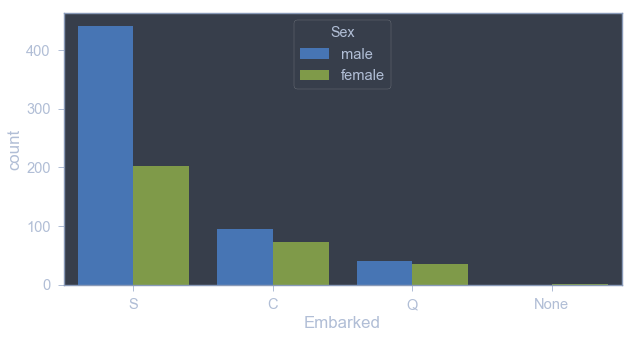

In [10]:
plt.figure(figsize(10, 5))
for feature in (cat_features):
    sns.countplot(x = feature, hue = 'Sex', data = data_train.fillna('None'))
    plt.show()

In [11]:
#Закодируем пол: 0 - если мужчина
data_train['Sex'] = data_train['Sex'].apply(lambda x: 0 if x == 'male' else 1)
data_test['Sex'] = data_test['Sex'].apply(lambda x: 0 if x == 'male' else 1)

#Fillna mode
data_train['Embarked'].fillna(data_train['Embarked'].mode()[0], inplace = True)

# Numeric features

In [12]:
numeric_features = ['Age', 'Fare']

In [13]:
data_train[numeric_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
Age     714 non-null float64
Fare    891 non-null float64
dtypes: float64(2)
memory usage: 14.0 KB


На первом графике виден пик выживаемости для возраста порядка 10 лет (дети)

Впоследствии разобъем возраст на категории.

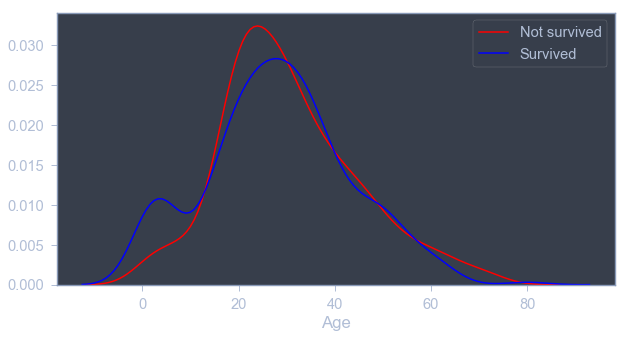

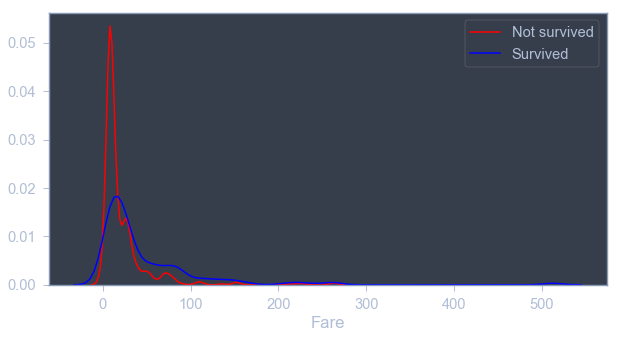

In [14]:
plt.figure(figsize(10, 5))
for feature in (numeric_features):
    sns.kdeplot(data_train[feature][data_train['Survived'] == 0], color = 'red', label = 'Not survived')
    plt.xlabel(feature)
    sns.kdeplot(data_train[feature][data_train['Survived'] == 1], color = 'blue', label = 'Survived')
    plt.xlabel(feature)
    plt.show()

В признаке Age имеются пропуски. Заменим все пропуски на уникальные значения и создадим для них уникальную категорию впоследствии

In [15]:
#Fillna Age unique
data_train['Age'].fillna(-100, inplace = True)
data_test['Age'].fillna(-100, inplace = True)

График Fare имеет длинный правый хвост. Удалим объекты, в которых значение этого признака больше, чем 99.5% квантиль. После пролагорифмирурем этот признак

У графика для невыживших наблюдается 3 пика: в нуле, около 2, и около 3.5

У графика для выживших большинство находится в диапазоне от 2 до 5

In [16]:
#99.5 % квантиль Fare
q1 = data_train['Fare'].quantile(0.995)

#Уберем выбросы
data_train.drop(data_train[data_train['Fare'] > q1].index, inplace = True)
target = data_train['Survived']

#Пролагорифмируем признак
data_train['Fare'] = np.log1p(data_train['Fare'] + 1)
data_test['Fare'] = np.log1p(data_test['Fare'] + 1)

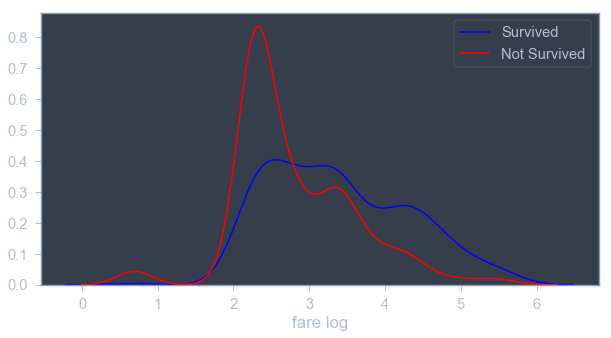

In [17]:
plt.figure(figsize(10, 5))
sns.kdeplot(data_train['Fare'][data_train['Survived'] == 1], color = 'blue', label = 'Survived')
sns.kdeplot(data_train['Fare'][data_train['Survived'] == 0], color = 'red', label = 'Not Survived')
plt.xlabel('fare log')
plt.show()

In [18]:
#Fare category function
def fare_cat(fare):
    if (0 <= fare <= 2.2):
        return 0
    elif (2.2 < fare <= 2.8):
        return 1
    elif (2.8 < fare <= 3.4):
        return 2
    else:
        return 3

#Fare category
data_train['Fare_category'] = data_train['Fare'].apply(fare_cat)
data_test['Fare_category'] = data_test['Fare'].apply(fare_cat)

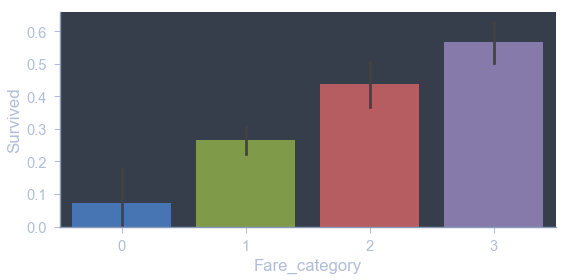

In [19]:
sns.catplot(x = 'Fare_category', y = 'Survived', data = data_train, kind = 'bar',
            height = 4, aspect = 2)
plt.show()

# Other features

In [20]:
other_features = ['Cabin', 'Name', 'Ticket']

In [21]:
data_train[other_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 3 columns):
Cabin     202 non-null object
Name      888 non-null object
Ticket    888 non-null object
dtypes: object(3)
memory usage: 49.3+ KB


Сформируем на основе первой буквы в Cabin категориальный признак

Пропуски заменим на уникальную категорию None

In [22]:
#fillna Cabin None
data_train['Cabin'].fillna('None', inplace = True)
data_test['Cabin'].fillna('None', inplace = True)

#Cabin category
data_train['Cabin'] = data_train['Cabin'].astype(str).str[0]
data_test['Cabin'] = data_test['Cabin'].astype(str).str[0]

Наблюдается очень много пропусков в Cabin. Однако выживаемость у группы с пропущенным значением самая низкая.

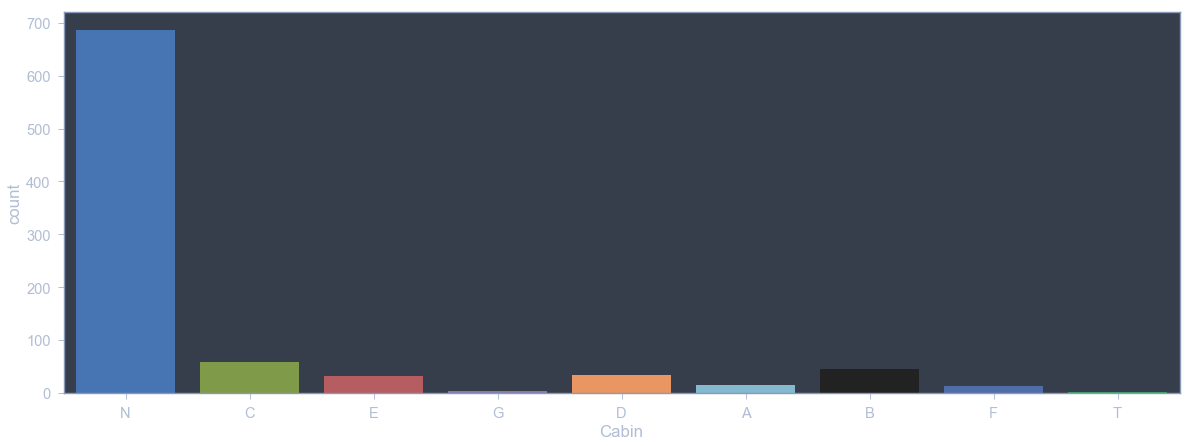

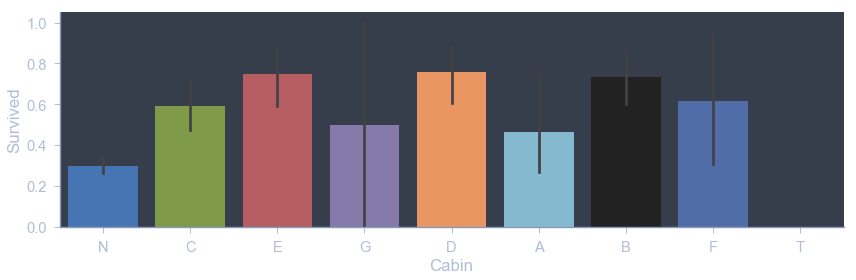

In [23]:
plt.figure(figsize = (20, 7))
sns.countplot(x = 'Cabin', data = data_train.fillna('None'))

sns.catplot(x = 'Cabin', y = 'Survived', data = data_train.fillna('None'), kind = 'bar', 
            height = 4, aspect = 3)
plt.show()

Признак Name имеет несколько категорий: Mr, Mrs etc.

Сформируем на основе этого еще один категориальный признак

In [24]:
data_train['Title'] = data_train['Name'].str.split(", ", expand = True)[1].str.split(".", expand = True)[0]
data_test['Title'] = data_test['Name'].str.split(", ", expand = True)[1].str.split(".", expand = True)[0]

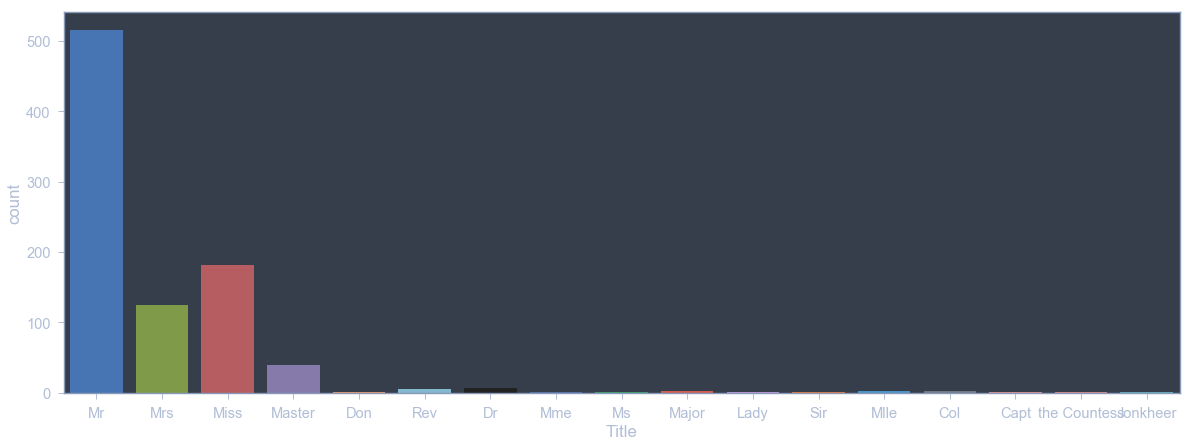

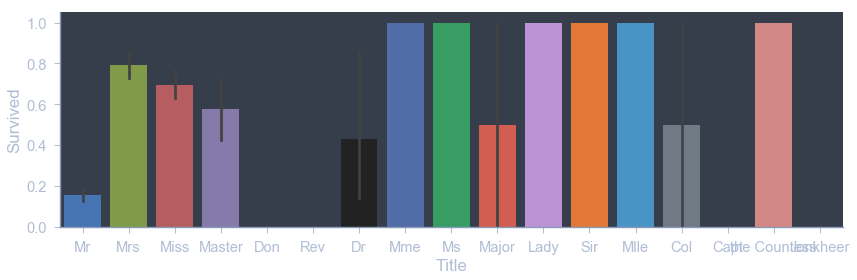

In [25]:
plt.figure(figsize = (20, 7))
sns.countplot(x = 'Title', data = data_train.fillna('None'))
plt.show()

sns.catplot(x = 'Title', y = 'Survived', data = data_train.fillna('None'), kind = 'bar',
            height = 4, aspect = 3)
plt.show()

In [26]:
#Объединим Mme, Ms, Lady, Mlle в Mrs
for title in (['Ms', 'Mme', 'Lady', 'Mlle']):
    data_train['Title'] = data_train['Title'].apply(lambda x: 'Mrs' if x == title else x)
    data_test['Title'] = data_test['Title'].apply(lambda x: 'Mrs' if x == title else x)

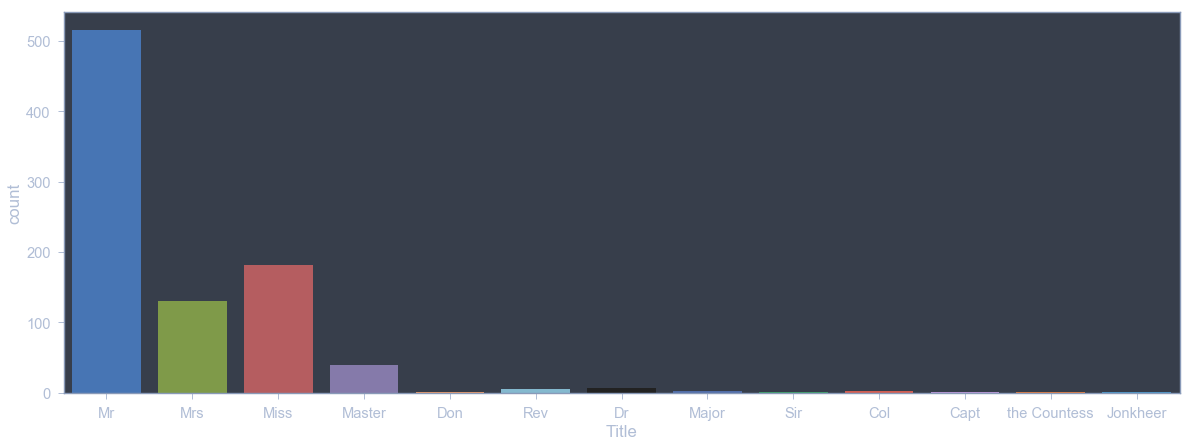

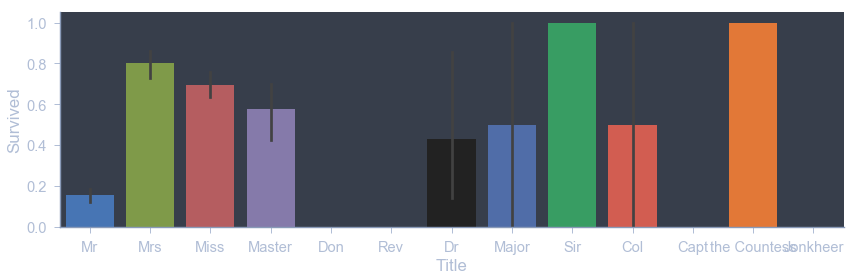

In [27]:
plt.figure(figsize = (20, 7))
sns.countplot(x = 'Title', data = data_train.fillna('None'))
plt.show()

sns.catplot(x = 'Title', y = 'Survived', data = data_train.fillna('None'), kind = 'bar',
            height = 4, aspect = 3)
plt.show()

In [28]:
#Объединим в отдельную группу редко встречающиеся категории
other_title_train = (data_train['Title'].value_counts() < 10)
data_train['Title'] = data_train['Title'].apply(lambda x: 'Other' if other_title_train.loc[x] == \
                                                True else x)

other_title_test = (data_test['Title'].value_counts() < 10)
data_test['Title'] = data_test['Title'].apply(lambda x: 'Other' if other_title_test.loc[x] == \
                                              True else x)

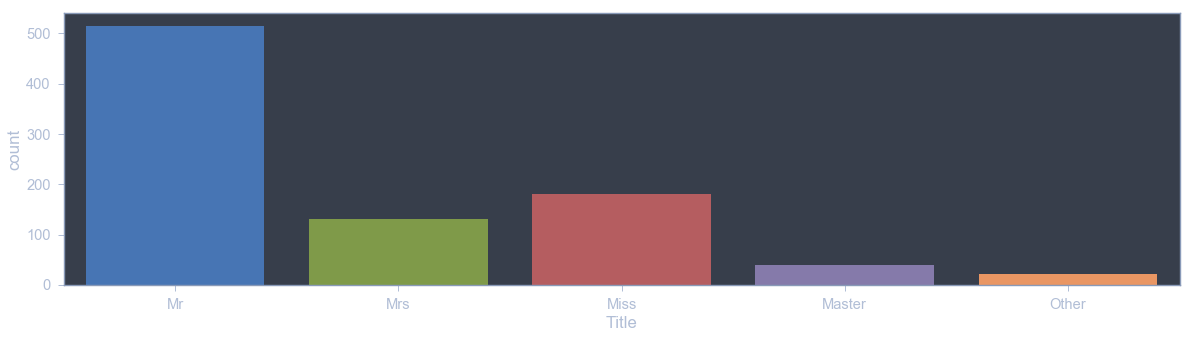

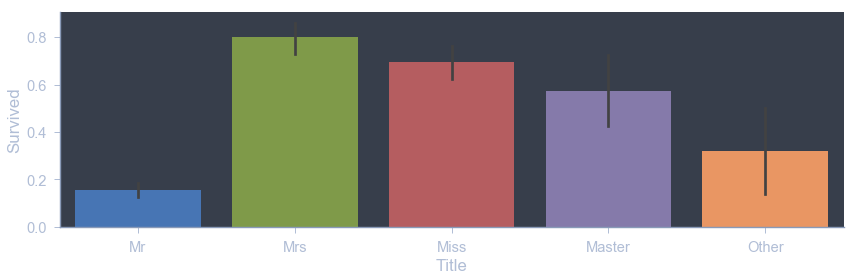

In [29]:
plt.figure(figsize = (20, 5))
sns.countplot(x = 'Title', data = data_train.fillna('None'))
plt.show()

sns.catplot(x = 'Title', y = 'Survived', data = data_train.fillna('None'), kind = 'bar',
            height = 4, aspect = 3)
plt.show()

In [30]:
#Age function
def age_cat(age):
    if age < 0:
        return 0
    if (0 <= age < 5):
        return 1
    elif (5 <= age <= 12):
        return 2
    elif (12 < age <= 18):
        return 3
    elif (18 < age <= 24):
        return 4
    elif (24 < age <= 35):
        return 5
    elif (35 < age <= 60):
        return 6
    else:
        return 7

#Age category
data_train['Age_category'] = data_train['Age'].apply(age_cat)
data_test['Age_category'] = data_test['Age'].apply(age_cat)

В 0 группе (в которой наблюдались пропуски) наблюдается одна из самых низких выживаемостей

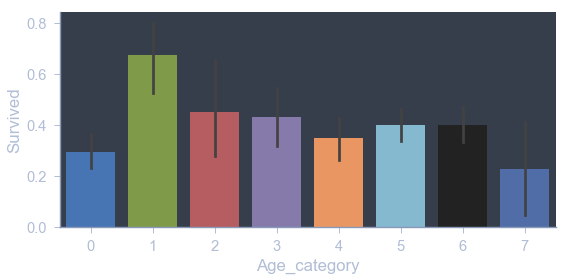

In [31]:
sns.catplot(x = 'Age_category', y = 'Survived', data = data_train.fillna('None'), kind = 'bar', 
                height = 4, aspect = 2)
plt.show()

In [32]:
#Ticket category train
ticket_train = []
for i in list(data_train['Ticket']):
    if not i.isdigit():
        ticket_train.append(i.replace(".", "").replace("/", "").strip().split(' ')[0]) #Take prefix
    else:
        ticket_train.append("X")
    
#Ticket category test  
ticket_test = []
for i in list(data_test['Ticket']):
    if not i.isdigit():
        ticket_test.append(i.replace(".", "").replace("/", "").strip().split(' ')[0]) #Take prefix
    else:
        ticket_test.append("X")

#Заменим Ticket на сформированные категории
data_train['Ticket'] = ticket_train
data_test['Ticket'] = ticket_test

#Закодируем категории
ticket_train = pd.get_dummies(data_train['Ticket'])
ticket_test = pd.get_dummies(data_test['Ticket'])

#Выровняем размерность
ticket_train, ticket_test = ticket_train.align(ticket_test, join = 'inner', axis = 1)

#Объединим датасеты
data_train = pd.concat([data_train, ticket_train], axis = 1)
data_test = pd.concat([data_test, ticket_test], axis = 1)

# Feature engineering

На основе изначальных признаков попробуем сформировать информативные признаки

In [33]:
#Количество родственников
data_train['Relatives'] = data_train['SibSp'] + data_train['Parch']
data_test['Relatives'] = data_test['SibSp'] + data_test['Parch']

#Маленькая по размеру семья
data_train['SmallFamily'] = data_train['Relatives'].apply(lambda x: 1 if 1 <= x <= 2 else 0 )
data_test['SmallFamily'] = data_test['Relatives'].apply(lambda x: 1 if 1 <= x <= 2 else 0)

#Средняя по размеру семья
data_train['MedianFamily'] = data_train['Relatives'].apply(lambda x: 1 if 2 < x <= 4 else 0)
data_test['MedianFamily'] = data_test['Relatives'].apply(lambda x: 1 if 2 < x <= 4 else 0)

#Большая по размеру семья
data_train['LargeFamily'] = data_train['Relatives'].apply(lambda x: 1 if x > 4 else 0)
data_test['LargeFamily'] = data_test['Relatives'].apply(lambda x: 1 if x > 4 else 0)

#Отсуствуют родственники
data_train['HasRelatives'] = data_train['Relatives'].apply(lambda x: 1 if x != 0 else 0)
data_test['HasRelatives'] = data_test['Relatives'].apply(lambda x: 1 if x != 0 else 0)

#Подростки без родствеников
idx_train = data_train.index[(data_train['Age_category'] == 2) & (data_train['Relatives'] == 0)]
data_train['Children_NoRelatives'] = np.zeros(len(data_train))
data_train.loc[idx_train, 'Children_NoRelatives'] = 1

idx_test = data_test.index[(data_test['Age_category'] == 2) & (data_test['Relatives'] == 0)]
data_test['Children_NoRelatives'] = np.zeros(len(data_test))
data_test.loc[idx_test, 'Children_NoRelatives'] = 1

Выживаемость у маленьких и средних по размеру семей выше

Выживаемость у больших семей ниже, чем у остальных


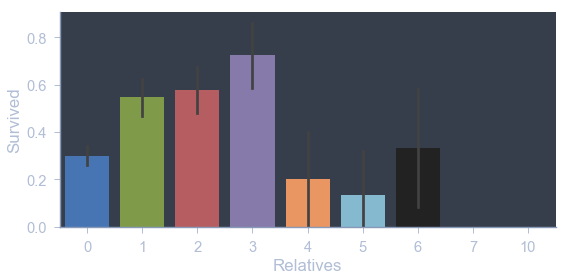

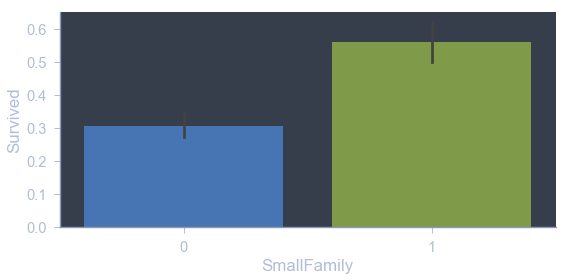

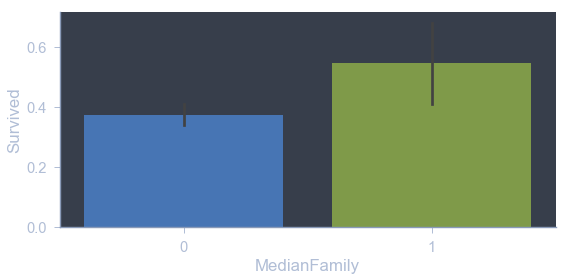

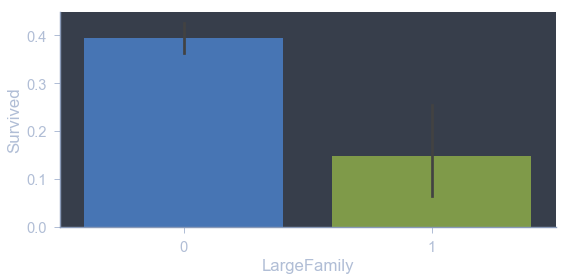

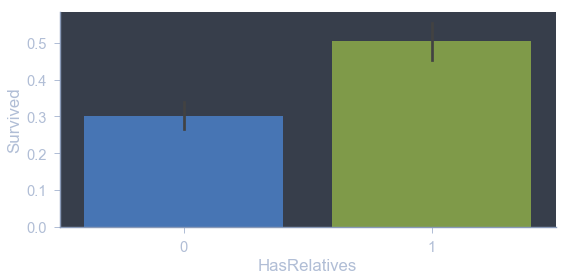

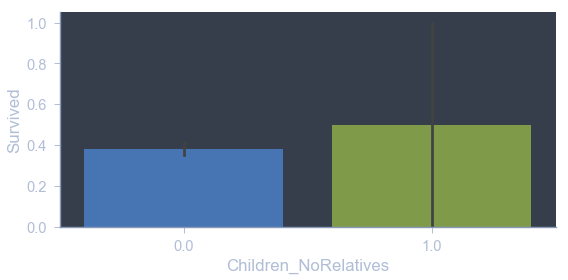

In [34]:
engineering_features = ['Relatives', 'SmallFamily', 'MedianFamily', 'LargeFamily', 
                        'HasRelatives', 'Children_NoRelatives']
for feature in (engineering_features):
    sns.catplot(x = feature, y = 'Survived', data = data_train.fillna('None'), kind = 'bar',
                height = 4, aspect = 2)
    plt.show()

# Target variable

В выборке классы достаточно сбалансированны

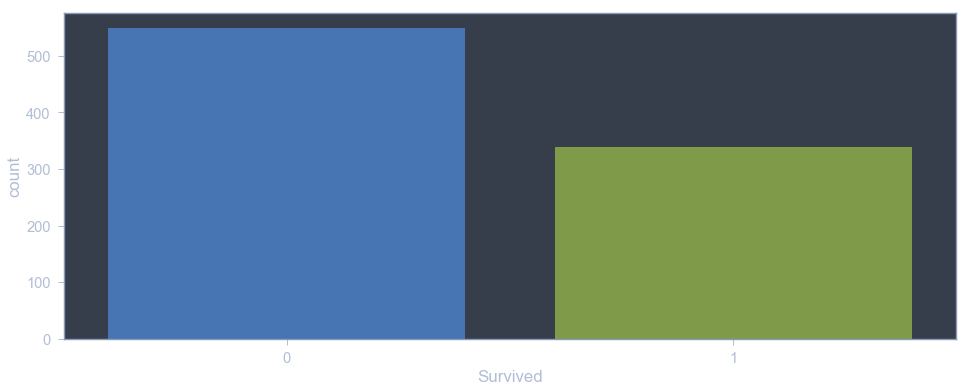

In [35]:
plt.figure(figsize = (16, 6))
sns.countplot(x = 'Survived', data = data_train.fillna('None'))
plt.show()

# Final dataset

In [36]:
data_train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,STONO2,WC,WEP,X,Relatives,SmallFamily,MedianFamily,LargeFamily,HasRelatives,Children_NoRelatives
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A5,2.224624,N,...,0,0,0,0,1,1,0,0,1,0.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC,4.294333,C,...,0,0,0,0,1,1,0,0,1,0.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STONO2,2.295057,N,...,1,0,0,0,0,0,0,0,0,0.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,X,4.009150,C,...,0,0,0,1,1,1,0,0,1,0.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,X,2.307573,N,...,0,0,0,1,0,0,0,0,0,0.0


In [37]:
#Удалим ненужные признаки
data_train.drop(columns = ['Name', 'Ticket', 'Age', 'SibSp', 'Parch', 'Fare'], axis = 1, inplace = True)
data_test.drop(columns = ['Name', 'Ticket', 'Age', 'SibSp', 'Parch', 'Fare'], axis = 1, inplace = True)

In [38]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 36 columns):
Survived                888 non-null int64
Pclass                  888 non-null int64
Sex                     888 non-null int64
Cabin                   888 non-null object
Embarked                888 non-null object
Fare_category           888 non-null int64
Title                   888 non-null object
Age_category            888 non-null int64
A4                      888 non-null uint8
A5                      888 non-null uint8
C                       888 non-null uint8
CA                      888 non-null uint8
FC                      888 non-null uint8
FCC                     888 non-null uint8
PC                      888 non-null uint8
PP                      888 non-null uint8
SC                      888 non-null uint8
SCA4                    888 non-null uint8
SCAH                    888 non-null uint8
SCPARIS                 888 non-null uint8
SCParis                 888 non-

In [39]:
#Категориальные признаки
cat_features = list(data_train.columns[data_train.dtypes == 'object'])

#Объединим датасеты
all_data = pd.concat([data_train.drop(columns = ['Survived'], axis = 1), data_test])

#OneHotEncoder
obj_dummies = pd.get_dummies(all_data[cat_features])

#Сформируем тестовую и обучающую выборку
data_train = pd.concat([all_data.iloc[:len(data_train)], obj_dummies.iloc[:len(data_train)],\
                       data_train['Survived']], axis = 1)
data_test = pd.concat([all_data.iloc[len(data_train):], obj_dummies.iloc[len(data_train):]], axis = 1)

In [40]:
data_train.head(5)

,Pclass,Sex,Cabin,Embarked,Fare_category,Title,Age_category,A4,A5,C,...,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Survived
0,3,0,N,S,1,Mr,4,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,1,1,C,C,3,Mrs,6,0,0,0,...,0,1,0,0,0,0,0,1,0,1
2,3,1,N,S,1,Miss,5,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,1,1,C,S,3,Mrs,5,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,3,0,N,S,1,Mr,5,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [41]:
#Удалим оставшиеся признаки, к которым применили OneHotEncoder
data_train.drop(columns = ['Embarked', 'Cabin', 'Title'], axis = 1, inplace = True)
data_test.drop(columns = ['Embarked', 'Cabin', 'Title'], axis = 1, inplace = True)

#Итоговые признаки
all_columns = list(data_train.columns)
all_columns.remove('Survived')

# Correlation analyz

Вычислим корреляцию Крамера

In [42]:
#V_kramer function
def V_kramer(data):
    hi2 = sts.chi2_contingency(data)[0]
    return np.sqrt(hi2 / (np.sum(data) * (min(data.shape) - 1)))

In [43]:
data_train['ID'] = np.arange(len(data_train))

#Вычислим корреляцию
corr_map = []
for feature in (all_columns):
    ticket_table = pd.pivot_table(data_train, values = 'ID', index = 'Survived', 
                               columns = feature, aggfunc = 'count', fill_value = 0)
    corr_map.append((feature, V_kramer(ticket_table.values)))
    
#Создадим датафрейм и остортируем по убыванию значения корреляции
corr_data = pd.DataFrame(corr_map, columns = ['Feature', 'V_kramer'])
corr_data = corr_data.sort_values(by = 'V_kramer', ascending = False)

#Удалим целевую переменную и ID
data_train.drop(columns = ['Survived', 'ID'], axis = 1, inplace = True)

Коэффициент Крамера показывает корреляцию между двумя категориальными переменными

Многие полученные признаки имеют высокую корреляцию с целевой переменной

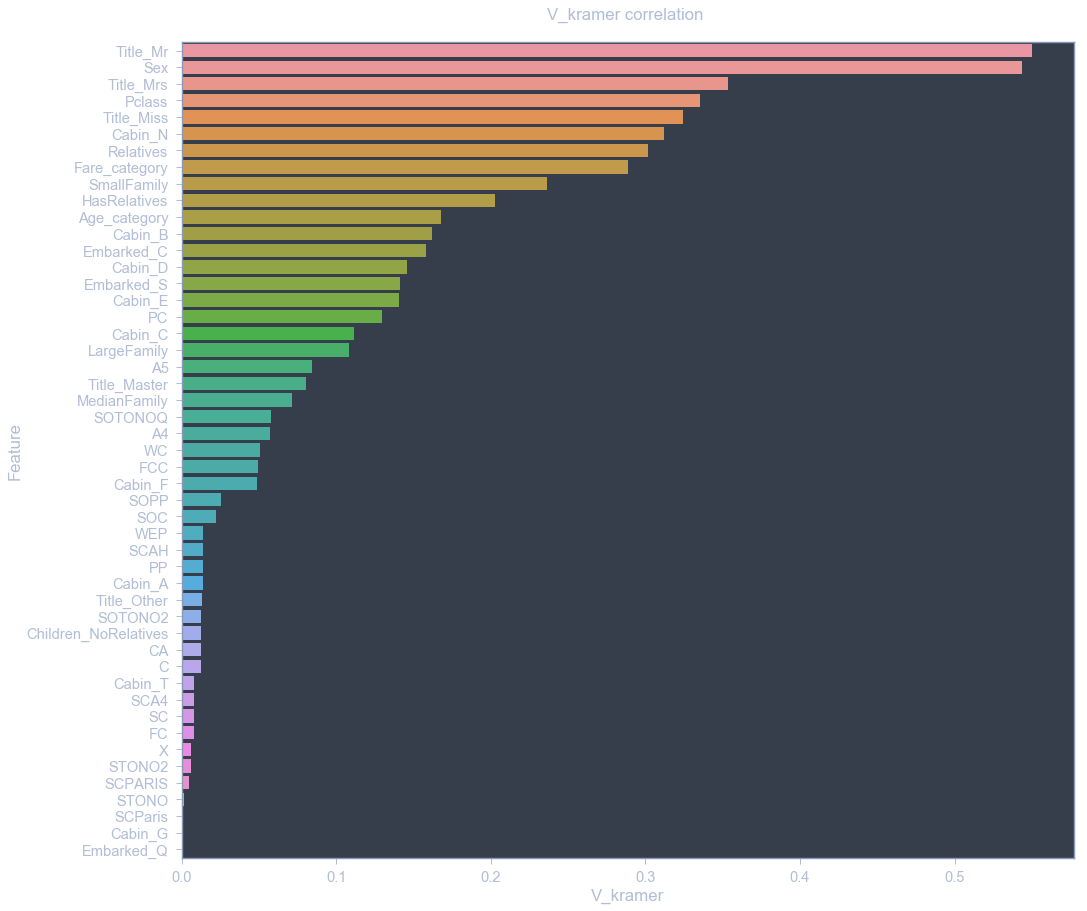

In [44]:
plt.figure(figsize = (16, 15))
sns.barplot(y = 'Feature', x = 'V_kramer', data = corr_data)
plt.title('V_kramer correlation \n')
plt.show()

# Feature selection

Обучим случайный лес и оценим наиболее значимые признаки

In [45]:
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(data_train, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

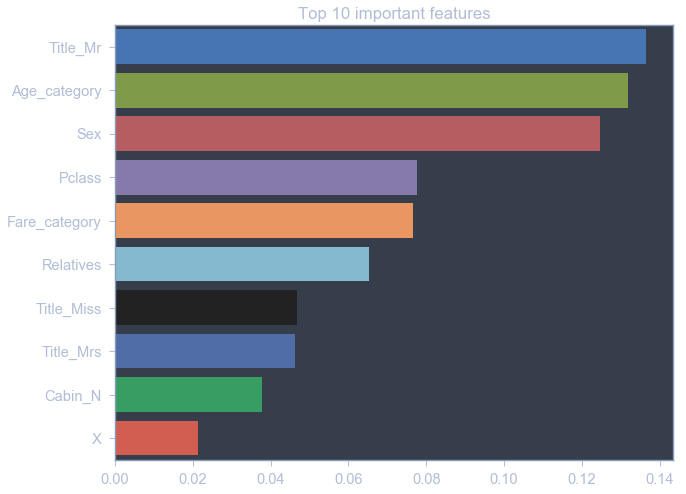

In [46]:
importances, features = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, all_columns), reverse = True)))
plt.figure(figsize = (10, 8))
sns.barplot(importances[:10], features[:10])
plt.title('Top 10 important features')
plt.show()

# CV Tuning models

Используем StratifiedKFold на 8 фолдов, заранее перемешивая выборку

Для линейных моделей масштабируем признаки с помощью RobustScaler

In [47]:
from sklearn.pipeline import Pipeline, make_pipeline
scaler = RobustScaler()
kf = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 42)

# Tune XGBoost

In [48]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', random_state = 42)

params_grid = {
               'max_depth' : [3, 4, 5, 6, 7, 8, 9],
               'min_child_weight' : np.arange(1, 12, 1)
}

grid_cv = GridSearchCV(xgb_model, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'max_depth': 4, 'min_child_weight': 7}
Accuracy on CV: 0.838963963963964


In [49]:
xgb_model = xgb.XGBClassifier(max_depth = 4, min_child_weight = 7, 
                              objective = 'binary:logistic', random_state = 42)

params_grid = {
               'subsample' : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               'colsample_bytree' : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_cv = GridSearchCV(xgb_model, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'subsample': 1.0, 'colsample_bytree': 1.0}
Accuracy on CV: 0.838963963963964


In [50]:
xgb_model = xgb.XGBClassifier(max_depth = 4, min_child_weight = 7, 
                              objective = 'binary:logistic', random_state = 42)

params_grid = {
               'reg_alpha' : np.arange(0, 0.1, 0.001),
}

grid_cv = GridSearchCV(xgb_model, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'reg_alpha': 0.0}
Accuracy on CV: 0.838963963963964


In [51]:
xgb_model = xgb.XGBClassifier(max_depth = 4, min_child_weight = 7, 
                              objective = 'binary:logistic', random_state = 42)

params_grid = {
               'gamma' : np.arange(0, 1, 0.1)
}

grid_cv = GridSearchCV(xgb_model, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'gamma': 0.0}
Accuracy on CV: 0.838963963963964


In [52]:
xgb_model = xgb.XGBClassifier(max_depth = 4, min_child_weight = 7, 
                              objective = 'binary:logistic', random_state = 42)


params_grid = {
               'n_estimators' : np.arange(50, 250, 10)
}

grid_cv = GridSearchCV(xgb_model, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'n_estimators': 120}
Accuracy on CV: 0.8400900900900901


In [53]:
xgb_model = xgb.XGBClassifier(n_estimators = 120, max_depth = 4, min_child_weight = 7, 
                              objective = 'binary:logistic', random_state = 42)
xgb_model.fit(data_train, target)
print 'Accuracy on train data:', (metrics.accuracy_score(target, xgb_model.predict(data_train)))

Accuracy on train data: 0.8671171171171171


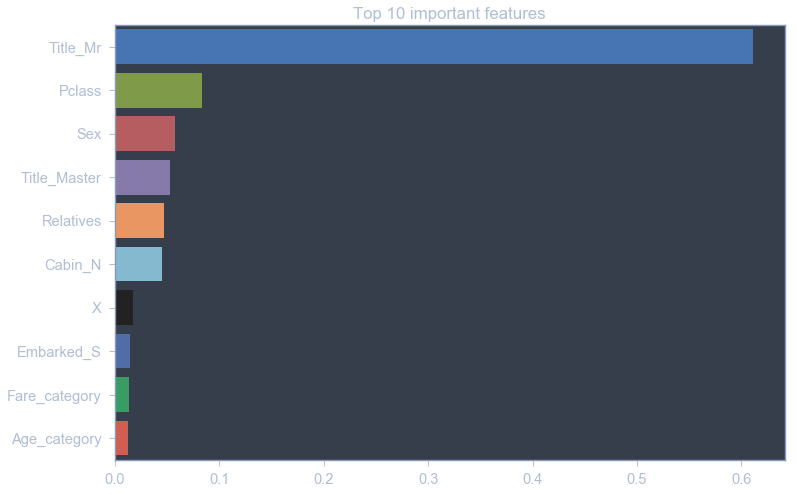

In [54]:
importances, features = (list(x) for x in zip(*sorted(zip(xgb_model.feature_importances_, all_columns), reverse = True)))
plt.figure(figsize = (12, 8))
sns.barplot(importances[:10], features[:10])
plt.title('Top 10 important features')
plt.show()

# Tune GradientBoostingCLassifier (AdaBoost)

In [55]:
gradboost = GradientBoostingClassifier(loss = 'exponential', random_state = 42)

params_grid = {
               'max_depth' : np.arange(2, 10, 1),
}

grid_cv = GridSearchCV(gradboost, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'max_depth': 2}
Accuracy on CV: 0.8322072072072072


In [56]:
gradboost = GradientBoostingClassifier(max_depth = 2, loss = 'exponential', 
                                       random_state = 42)

params_grid = {
               'min_samples_split' : np.arange(2, 18, 1),
               'min_samples_leaf' : np.arange(1, 10, 1)
}

grid_cv = GridSearchCV(gradboost, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'min_samples_split': 5, 'min_samples_leaf': 2}
Accuracy on CV: 0.8400900900900901


In [57]:
gradboost = GradientBoostingClassifier(max_depth = 2, loss = 'exponential',
                                       min_samples_split = 5, min_samples_leaf = 2,
                                       random_state = 42)

params_grid = {
               'max_features' : np.arange(1, data_train.shape[1] + 1, 1)
}

grid_cv = GridSearchCV(gradboost, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'max_features': 38}
Accuracy on CV: 0.8400900900900901


In [58]:
gradboost = GradientBoostingClassifier(max_depth = 2, loss = 'exponential',
                                       min_samples_split = 5, min_samples_leaf = 2,
                                       max_features = 38, random_state = 42)

params_grid = {
               'subsample' : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_cv = GridSearchCV(gradboost, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'subsample': 1.0}
Accuracy on CV: 0.8400900900900901


In [59]:
gradboost = GradientBoostingClassifier(max_depth = 2, loss = 'exponential',
                                       min_samples_split = 5, min_samples_leaf = 2,
                                       max_features = 38, random_state = 42)

params_grid = {
               'n_estimators' : np.arange(50, 250, 10)
}

grid_cv = GridSearchCV(gradboost, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'n_estimators': 100}
Accuracy on CV: 0.8400900900900901


In [60]:
gradboost = GradientBoostingClassifier(max_depth = 2, loss = 'exponential',
                                       min_samples_split = 5, min_samples_leaf = 2,
                                       max_features = 38, random_state = 42)
gradboost.fit(data_train, target)
print 'Accuracy on train data:', (metrics.accuracy_score(target, gradboost.predict(data_train)))

Accuracy on train data: 0.8513513513513513


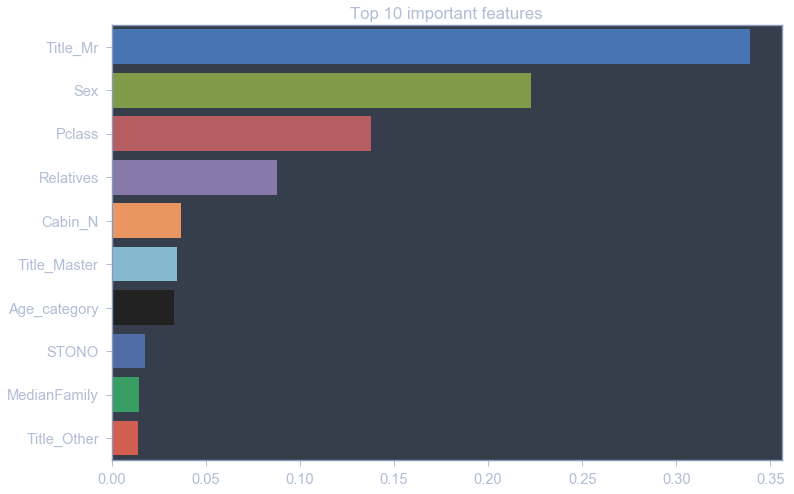

In [61]:
importances, features = (list(x) for x in zip(*sorted(zip(gradboost.feature_importances_, all_columns), reverse = True)))
plt.figure(figsize = (12, 8))
sns.barplot(importances[:10], features[:10])
plt.title('Top 10 important features')
plt.show()

# Tune SVC

In [62]:
svc = SVC(kernel = 'rbf', probability = True, random_state = 42)
svc_pipeline = Pipeline(steps = [('scaler', scaler), ('svc', svc)])

params_grid = {
              'svc__C' : np.arange(0.1, 1, 0.1),
              'svc__gamma' : np.arange(0.01, 0.5, 0.01)
}

grid_cv = GridSearchCV(svc_pipeline, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

D:\Python\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'svc__gamma': 0.42000000000000004, 'svc__C': 0.4}
Accuracy on CV: 0.838963963963964


In [63]:
svc = SVC(kernel = 'rbf', C = 0.4, gamma = 0.42, probability = True, random_state = 42)
svc_pipeline = Pipeline(steps = [('scaler', scaler), ('svc', svc)])
svc_pipeline.fit(data_train, target)
print 'Accuracy on train data:', metrics.accuracy_score(target, svc_pipeline.predict(data_train))

Accuracy on train data: 0.8614864864864865


# Tune Random Forest

In [64]:
rf = RandomForestClassifier(random_state = 42)

params_grid = {
              'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20],
}

grid_cv = GridSearchCV(rf, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

D:\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'max_depth': 6}
Accuracy on CV: 0.829954954954955


D:\Python\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [65]:
rf = RandomForestClassifier(max_depth = 6, random_state = 42)

params_grid = {
              'min_samples_split' : np.arange(2, 15, 1)
}

grid_cv = GridSearchCV(rf, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'min_samples_split': 3}
Accuracy on CV: 0.831081081081081


In [66]:
rf = RandomForestClassifier(max_depth = 6, min_samples_split = 3,
                            random_state = 42)

params_grid = {
              'min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
}

grid_cv = GridSearchCV(rf, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'min_samples_leaf': 7}
Accuracy on CV: 0.8322072072072072


In [67]:
rf = RandomForestClassifier(max_depth = 6, min_samples_split = 3,
                            min_samples_leaf = 7, random_state = 42)

params_grid = {
              'max_features' : np.arange(1, data_train.shape[1] + 1, 1)
}

grid_cv = GridSearchCV(rf, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'max_features': 28}
Accuracy on CV: 0.8378378378378378


D:\Python\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [68]:
rf = RandomForestClassifier(max_depth = 6, min_samples_split = 3,
                            min_samples_leaf = 7, max_features = 28,
                            random_state = 42)
params_grid = {
              'n_estimators' : np.arange(10, 150, 10)
}

grid_cv = GridSearchCV(rf, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'n_estimators': 10}
Accuracy on CV: 0.8378378378378378


In [69]:
rf = RandomForestClassifier(max_depth = 6, min_samples_split = 3,
                            min_samples_leaf = 7, max_features = 28,
                            n_estimators = 10, random_state = 42)
rf.fit(data_train, target)
print 'Accuracy on train data:', metrics.accuracy_score(target, rf.predict(data_train))

Accuracy on train data: 0.847972972972973


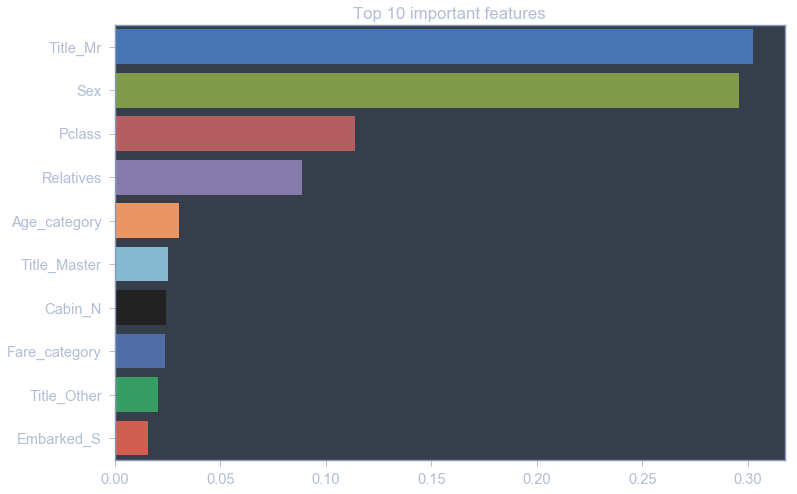

In [70]:
importances, features = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, all_columns), reverse = True)))
plt.figure(figsize = (12, 8))
sns.barplot(importances[:10], features[:10])
plt.title('Top 10 important features')
plt.show()

# Tune logistic regression

In [71]:
logreg = linear_model.LogisticRegression(solver = 'liblinear', random_state = 42)
logreg_pipeline = Pipeline(steps = [('scaler', scaler), ('logreg', logreg)])

params_grid = {
              'logreg__penalty' : ['l1', 'l2']
}

grid_cv = GridSearchCV(logreg_pipeline, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'logreg__penalty': 'l1'}
Accuracy on CV: 0.8277027027027027


In [72]:
logreg = linear_model.LogisticRegression(solver = 'liblinear', penalty = 'l1', random_state = 42)
logreg_pipeline = Pipeline(steps = [('scaler', scaler), ('logreg', logreg)])

params_grid = {
              'logreg__C' : np.arange(0.01, 1, 0.01)
}

grid_cv = GridSearchCV(logreg_pipeline, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'logreg__C': 0.68}
Accuracy on CV: 0.8322072072072072


D:\Python\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [73]:
logreg = linear_model.LogisticRegression(C = 0.68, solver = 'liblinear', penalty = 'l1', random_state = 42)
logreg_pipeline = Pipeline(steps = [('scaler', scaler), ('logreg', logreg)])
logreg_pipeline.fit(data_train, target)
print 'Accuracy on train data:', metrics.accuracy_score(target, logreg_pipeline.predict(data_train))

Accuracy on train data: 0.8412162162162162


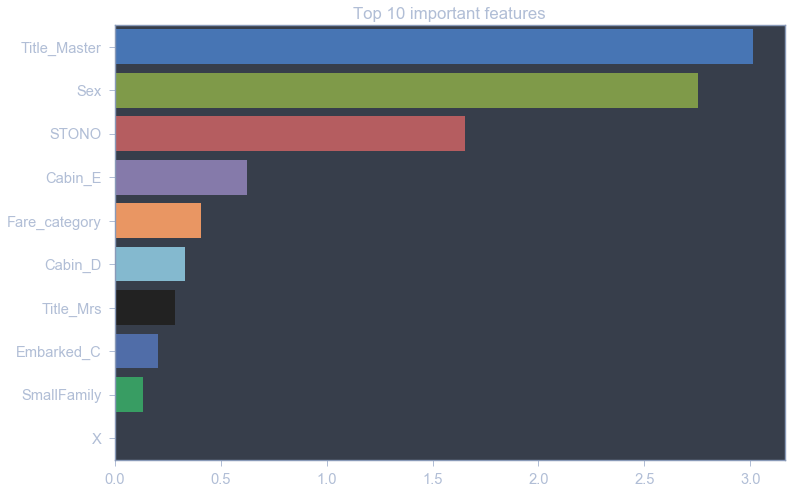

In [74]:
importances, features = (list(x) for x in zip(*sorted(zip(np.ravel(logreg.coef_), all_columns), reverse = True)))
plt.figure(figsize = (12, 8))
sns.barplot(importances[:10], features[:10])
plt.title('Top 10 important features')
plt.show()

# Voting Classifier

In [75]:
from sklearn.ensemble import VotingClassifier

In [76]:
vot_class = VotingClassifier(estimators = [('svc', svc_pipeline), ('xgb_model', xgb_model),
                                           ('gradboost', gradboost),  ('rf', rf),
                                           ('logreg', logreg_pipeline)])

params_grid = {
              'voting' : ['soft', 'hard']
}

grid_cv = GridSearchCV(vot_class, params_grid, cv = kf, scoring = 'accuracy')
grid_cv.fit(data_train, target)
print grid_cv.best_params_
print 'Accuracy on CV:', grid_cv.best_score_

{'voting': 'soft'}
Accuracy on CV: 0.8367117117117117


In [78]:
#voting classifier
vot_class = VotingClassifier(estimators = [('svc', svc_pipeline), ('xgb_model', xgb_model),
                                           ('gradboost', gradboost), ('rf', rf),
                                           ('logreg', logreg_pipeline)],
                                            voting = 'soft')

#fit vot_class
vot_class.fit(data_train, target)

VotingClassifier(estimators=[('svc', Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svc', SVC(C=0.4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.42, kernel='rbf',...y='l1', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

# Predict submission

In [79]:
submission = vot_class.predict(data_test)

In [80]:
answer = pd.DataFrame({'Survived': submission}, index = id_test)
answer.head(5)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [83]:
answer.to_csv('Kaggle_titanic.csv')